In [303]:
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Activation, Input
from keras.optimizers import RMSprop
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
PADDING = 25

In [3]:
def padding(res_len, x):
    return '#' * (res_len - len(x)) + x

In [175]:
def cutting(max_len, x): 
    # rework to cut from begin, not from the end! (however, it's mb not neccesary beacause all long words are zeros)
    return x if len(x) <= max_len else x[:max_len]

In [190]:
def create_output(res, out_f):
    with open(out_f, mode='w') as out:
        out.write('Id,Answer\n')
        for i, o in enumerate(res):
            out.write(str(i) + ',' + str(o) + '\n')

In [52]:
X_text = []
y_text = []
all_text = ""
word_lens = []
with open('Data/linear_train.txt') as f:
    for line in f:
        splited_line = line.split()
        text = splited_line[0].strip(',').lower()
        X_text.append(padding(PADDING, text))
        y_text.append(int(splited_line[-1]))
        all_text+=padding(PADDING, text)
        word_lens.append(len(text))

25


(array([  1.45300000e+03,   1.30400000e+04,   4.21390000e+04,
          2.25870000e+04,   1.29720000e+04,   7.41000000e+03,
          1.27700000e+03,   4.82000000e+02,   4.10000000e+01,
          7.00000000e+00]),
 array([  1. ,   3.4,   5.8,   8.2,  10.6,  13. ,  15.4,  17.8,  20.2,
         22.6,  25. ]),
 <a list of 10 Patch objects>)

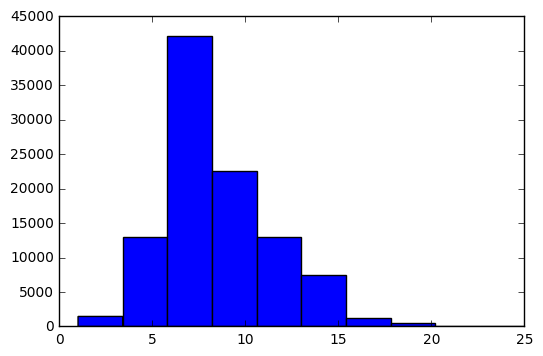

In [53]:
print(max(word_lens))
plt.hist(word_lens)

In [54]:
chars = sorted(list(set(all_text)))

In [55]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [56]:
X = np.zeros((len(X_text), PADDING, len(chars)), dtype=np.bool)
y = np.zeros((len(X_text), 2), dtype=np.int)

In [57]:
for i, sentence in enumerate(X_text):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, y_text[i]] = 1

# Linear Model Approach

In [64]:
sk_model = LogisticRegression()
sk_model.fit(X.reshape(len(X_text), PADDING * len(chars)), y_text)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

score on train

In [75]:
roc_auc_score(y_text, sk_model.predict_proba(X.reshape(len(X_text), PADDING * len(chars)))[:,1])

0.82072705479842889

In [174]:
X_test_text = []
with open('Data/linear_test.txt') as f:
    for l in f:
        delete_chars = 'á &“7`ë0«»"ô1'
        line = l.strip().strip('\ufeff').replace('\\', '').replace('\xa0', '')
        for d_c in delete_chars:
            line = line.replace(d_c, '')
        line = padding(PADDING,cutting(PADDING, line))
        X_test_text.append(line.lower())

In [176]:
X_test = np.zeros((len(X_test_text), PADDING, len(chars)), dtype=np.bool)

In [177]:
for i, sentence in enumerate(X_test_text):
    for t, char in enumerate(sentence):
        X_test[i, t, char_indices[char]] = 1

In [185]:
lr_res = sk_model.predict_proba(X_test.reshape(len(X_test), PADDING * len(chars)))[:, 1]

In [192]:
create_output(lr_res, 'linear_output.txt')

# Dense

In [261]:
model = Sequential()
model.add(Dense(input_dim=PADDING * len(chars), output_dim=64, activation='relu'))
model.add(Dense(output_dim=32, activation='relu'))
model.add(Dense(output_dim=16, activation='relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [262]:
model.fit(X.reshape(len(X_text), PADDING * len(chars)), y)

Epoch 1/10
101408/101408 [==============================] - 11s - loss: 0.2867    
Epoch 2/10
101408/101408 [==============================] - 10s - loss: 0.2728    
Epoch 3/10
101408/101408 [==============================] - 10s - loss: 0.2727    
Epoch 4/10
101408/101408 [==============================] - 10s - loss: 0.2914    
Epoch 5/10
101408/101408 [==============================] - 10s - loss: 0.3056    
Epoch 6/10
101408/101408 [==============================] - 10s - loss: 0.3168    
Epoch 7/10
101408/101408 [==============================] - 11s - loss: 0.2981    
Epoch 8/10
101408/101408 [==============================] - 11s - loss: 0.3157    
Epoch 9/10
101408/101408 [==============================] - 11s - loss: 0.3344    
Epoch 10/10
101408/101408 [==============================] - 11s - loss: 0.3645    


In [263]:
roc_auc_score(y_text, model.predict(X.reshape(len(X_text), PADDING * len(chars)))[:,1])

0.82845795470529204

# Simple RNN, LSTM, GRU
fix to gru or rnn (less parameters number)

In [304]:
model = Sequential()
model.add(GRU(32, input_shape=(PADDING, len(chars))))
model.add(Dense(2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [305]:
model.fit(X, np.array(y), nb_epoch=1)

Epoch 1/1
101408/101408 [==============================] - 159s - loss: 0.2560   


In [306]:
roc_auc_score(y_text, model.predict(X)[:,1])

0.86587267323291162

In [300]:
lstm_res = model.predict(X_test)

In [301]:
lstm_res[:, 1]

array([ 0.21837008,  0.19378947,  0.27904779, ...,  0.02553153,
        0.00136087,  0.00304305], dtype=float32)

In [302]:
create_output(lstm_res[:,1], 'charRNN_for_fun_32_1_epoch(GRU).txt')